# I. Relevant Imports & loading

In [16]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
import scipy.cluster.hierarchy as shc
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.features import PCA

from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


loading clean data and extracting an array for modelling purposes

In [125]:
tickers = pd.read_csv('tickers_final.csv')

In [2]:
df = pd.read_csv('clean_data.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [3]:
complete1 = df.iloc[:,1:28]

# II. Scaling data for modelling

We use StandardScaler as our method computing the z-score for each observation.

In [4]:
sc = StandardScaler()
complete1_scaled = sc.fit_transform(complete1)

# III. Principal Component Analysis (PCA)

We test PCA here prior to clustering to see if we can simplify the dimensionality in the dataset

In [5]:
pca_alt = PCA(n_components = None)
pca_complete1_scaled = pca_alt.fit_transform(complete1_scaled)

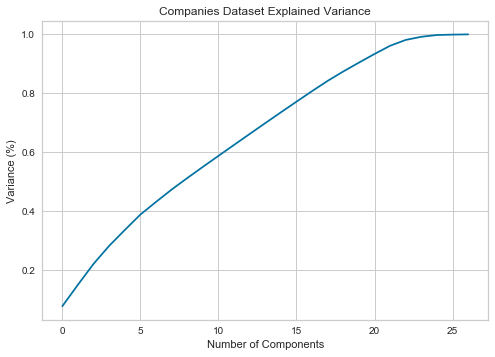

In [6]:
plt.figure()
plt.plot(np.cumsum(pca_alt.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Companies Dataset Explained Variance')
plt.show()

In [7]:
pca_alt = PCA(n_components = 23)
alt30 = pca_alt.fit_transform(complete1_scaled)
print('23 principal components explain:', pca_alt.explained_variance_ratio_.sum(), 'of the data variance')

23 principal components explain: 0.9811376200367439 of the data variance


In [8]:
alt_df = pd.DataFrame(alt30, columns=[f'PC{x+1}' for x in range((pca_alt.n_components_))])

alt_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
0,-1.005843,0.481199,5.101498,0.089538,-13.541418,-3.067082,3.307921,1.146352,-0.300967,0.139215,...,0.507754,0.578179,-0.212332,-0.044184,-0.878173,-0.592459,0.472801,-0.451458,-1.283281,-15.045729
1,-1.813818,1.306174,8.650017,0.142135,-25.587431,-5.869535,6.377882,1.870509,-0.790759,0.327951,...,0.908642,0.896433,-0.486427,0.279714,0.197316,-0.122635,0.341679,-0.951630,-1.082172,-9.552885
2,-0.565998,-0.025622,2.535041,-0.038812,-5.949170,-3.096502,0.217566,0.827674,0.050900,0.292614,...,0.453284,0.137622,-0.322196,0.290186,0.485188,-1.103649,0.095274,0.812278,0.840421,-7.805763
3,-0.720647,0.419112,3.023505,0.033532,-9.481429,-3.364922,0.556363,1.144766,1.531217,0.113747,...,0.968637,0.210578,-0.444655,-0.531481,0.151787,-1.160301,0.034264,1.171804,1.563625,0.609390
4,-0.317726,0.783534,0.392928,0.007687,-1.268800,-0.397266,-0.039241,-0.026658,0.076277,-0.072112,...,-0.029409,-0.151209,-0.096920,0.106117,0.390310,-0.197276,0.141744,-0.043493,0.378935,0.372608


Evaluating effect of PCA:

- We could reduce the dataset to 23 principal components as opposed to 27 and preserve most of the variance of the data. 
- We will run clustering on PCA data but considering the limited effect of PCA on this data we will focus on non-PCA data.

In [20]:
complete1.head()

,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,metric.netProfitMargin%Annual,metric.netProfitMargin5Y,metric.dividendGrowthRate5Y,...,metric.freeCashFlowAnnual,metric.longTermDebt/equityAnnual,metric.netInterestCoverageAnnual,metric.payoutRatioAnnual,metric.quickRatioAnnual,metric.totalDebt/totalEquityAnnual,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual
0,410825.30,1934379.0,11.284440,19.40911,18.63398,38.718250,37.817770,21.23809,21.89832,11.229900,...,44777.0,101.45760,23.609307,25.570070,1.501290,119.40480,1.486500,1.275840,1.352890,40.134460
1,133155.30,442932.0,6.690699,29.93606,61.20183,52.764357,54.018287,30.06225,25.11008,38.208420,...,55843.0,81.79525,22.797158,23.640280,0.788504,161.45800,1.589900,3.594610,12.762828,7.640894
2,16052.58,388131.4,15.074940,6.57306,7.71885,38.289440,40.990010,4.13586,2.87305,19.595689,...,21653.0,65.27393,18.933590,38.788651,0.863630,67.37995,2.882723,5.395433,28.074190,8.788510
3,58268.48,705031.1,6.973920,5.05381,7.91697,53.188140,53.562780,8.26467,8.60255,2.041380,...,14345.0,82.13450,3.773710,108.115100,0.753100,88.56048,5.342350,7.574650,-1.722560,29.863710
4,-155641.00,3219231.0,170.816300,3.70202,6.06133,47.072970,50.629230,-4.83473,25.37806,12.018900,...,1522.0,434.61910,23.397624,188.957059,0.309640,450.69110,4.390640,8.981560,8.579920,5.362020


# IV. KMeans Clustering - PCA Data

- We use the 'Elbow' method to look for the optimal number of clusters. 
- We don't treat the elbow method as absolute truth but use it as an indicator of where our model potentially fits best.
- We use two variants of the elbow method: Distortion (sum of squared distances from centroid) / clainski_harabasz (ratio of dispersion between / within clusters)
- The elbow method works well for closely clustered data.

In [50]:
km = KMeans()
visualizer = KElbowVisualizer(km, k=(4,80))

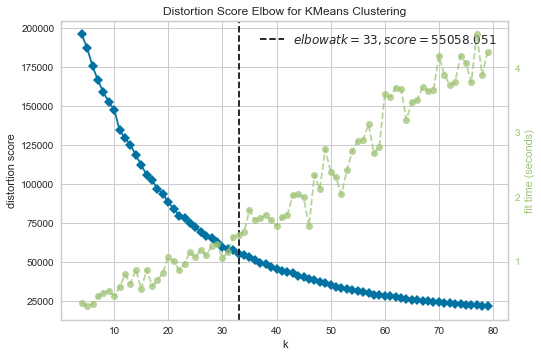

In [51]:
visualizer.fit(alt_df)
visualizer.poof().get_figure()

In [61]:
visualizer1 = KElbowVisualizer(km, k=(4,80), metric ='calinski_harabasz', locate_elbow = True)
visualizer1.fit(alt_df)

Limited results with this second method

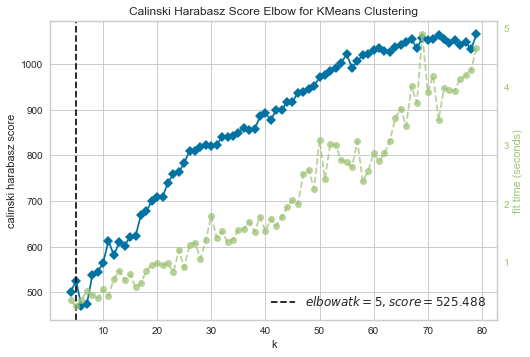

In [63]:
visualizer1.poof().get_figure()

In [10]:
number_clusters = 33
pca_km_alt = KMeans(n_clusters = number_clusters, n_init = 10, random_state =0)
pca_km_alt.fit(alt_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=33, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [11]:
predicted_alt_pca = pca_km_alt.predict(alt_df)

In [12]:
predicted_alt_pca

array([ 3,  3, 24, ..., 17, 17, 17], dtype=int32)

No cluster separation visible within the elected principal components below

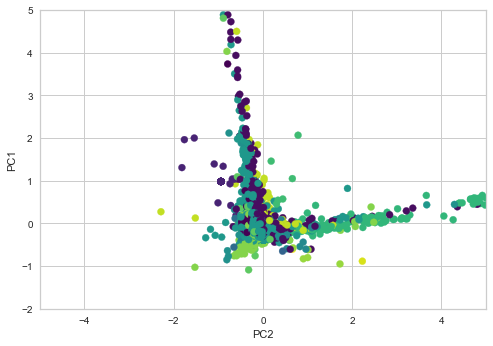

In [13]:
plt.axis([-5,5,-2,5])
plt.ylabel('PC1')
plt.xlabel('PC2')
plt.scatter(alt30[:,0], alt30[:,1], c = predicted_alt_pca, cmap = 'viridis')

From the below we notice clusters that deal with bunched data combined with outliers
 - multidimensional scaling used

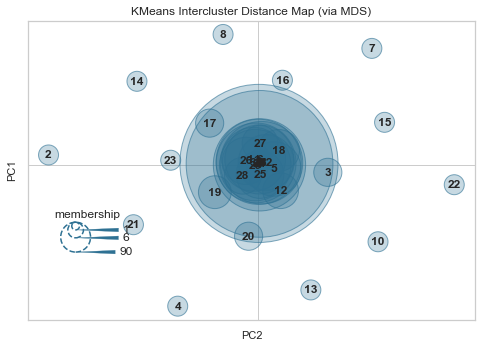

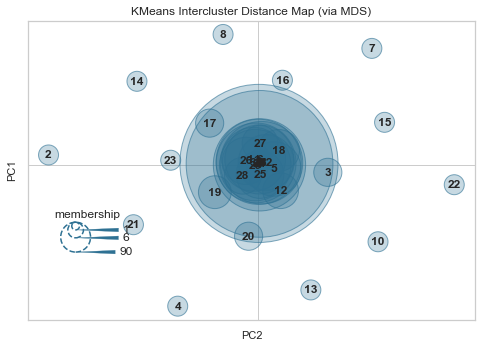

In [14]:
model = KMeans(33)
int_clust_dist = InterclusterDistance(model)
int_clust_dist.fit(alt_df)
int_clust_dist.poof().get_figure()

Adding another dimension to understand data dispersion

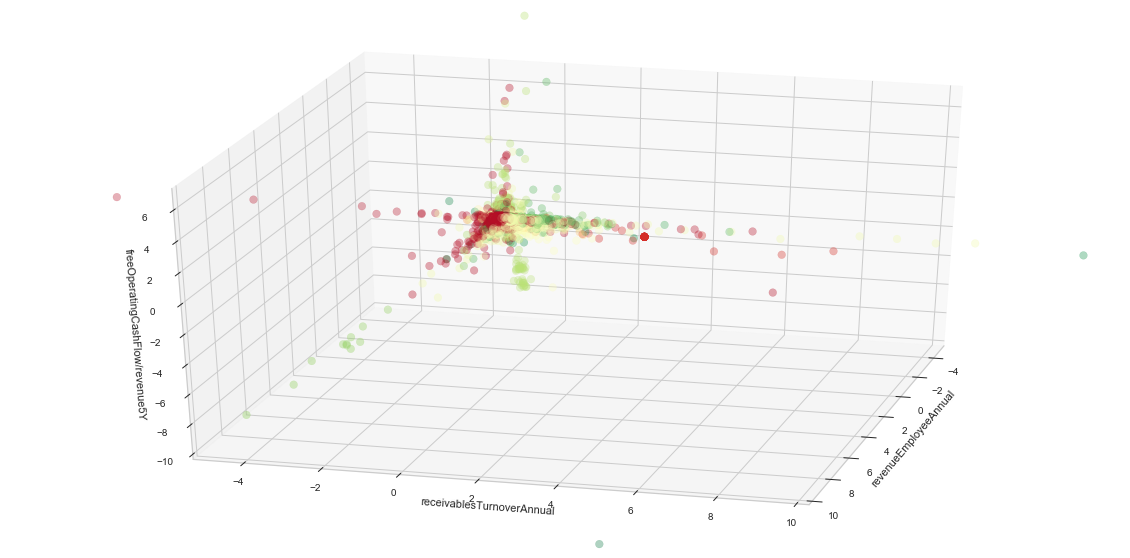

In [15]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('revenueEmployeeAnnual') #check PCA extraction
ax.set_ylabel('receivablesTurnoverAnnual') #check PCA extraction
ax.set_zlabel('freeOperatingCashFlow/revenue5Y') #check PCA extraction
ax.scatter(alt30[:,1], alt30[:,2], alt30[:,3], c=predicted_alt_pca , s=60,cmap="RdYlGn")
ax.set_xlim3d(-5, 10)
ax.set_ylim3d(-5,10)
ax.set_zlim3d(-10,7)
ax.view_init(30, 15)
plt.show()

# V. KMeans Clustering - without PCA data


In [25]:
km = KMeans()
elbow = KElbowVisualizer(km, k=(4,80))

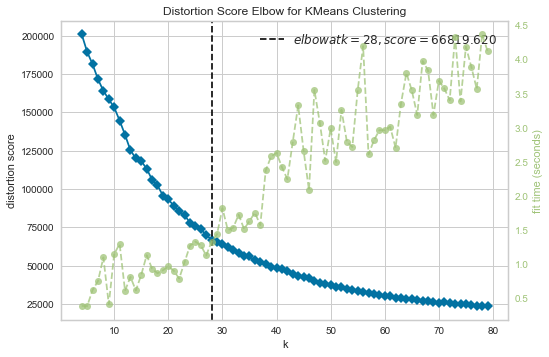

In [27]:
elbow.fit(complete1_scaled)
elbow.poof().get_figure()

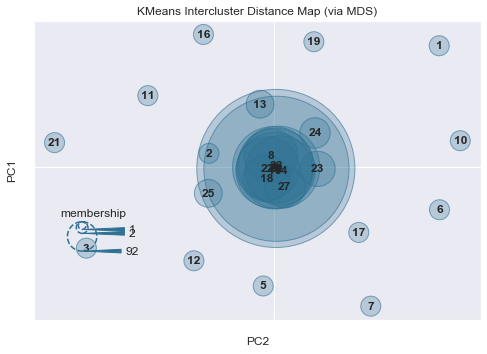

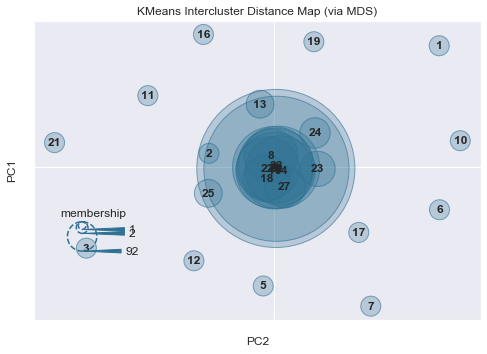

In [36]:
model = KMeans(28)
int_clust_dist_1 = InterclusterDistance(model)
int_clust_dist_1.fit(alt_df)
int_clust_dist_1.poof().get_figure()

From the displays above we understand some of the limitations of using the elbow method to find the 'optimal' number of clusters. 

    - We consider our data and devide to increase the number of clusters to simplify the inspection of clusters


In [37]:
alt_km = KMeans(n_clusters = 100, n_init = 10, random_state =0)
alt_km.fit(complete1_scaled)
pred_alt = alt_km.predict(complete1_scaled)
alt_df_2 = pd.DataFrame(pred_alt, columns = ['company cluster'])
alt_df_2.reset_index(inplace = True)
alt_df_2['companies'] = 1

In [38]:
clusters = pd.pivot_table(alt_df_2,  values = 'companies', index = 'company cluster', aggfunc = np.sum)
clusters = clusters.reset_index().sort_values(by = 'companies', ascending = False)

Text(0.5, 1.0, 'KMeans Clusters')

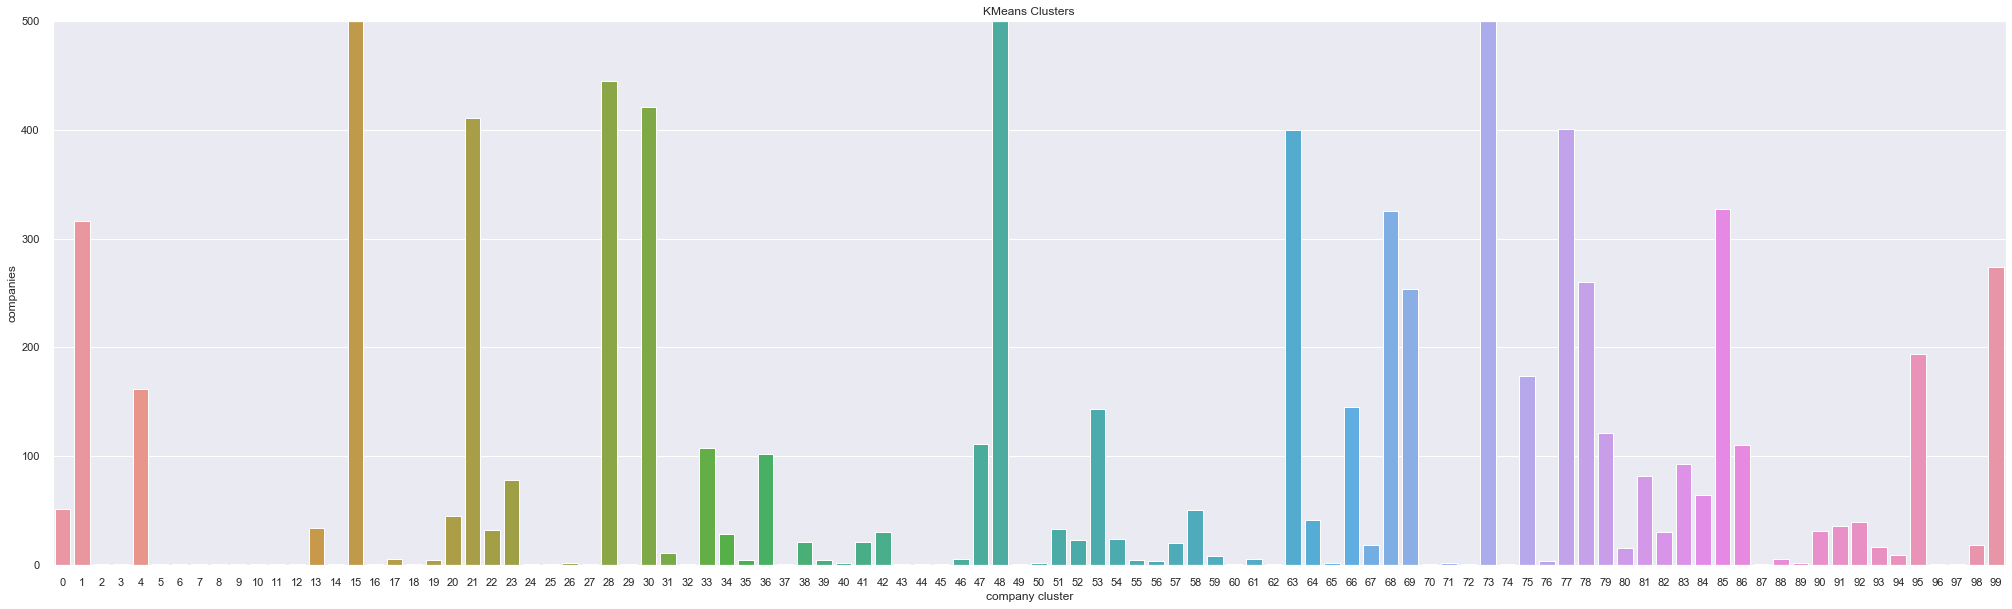

In [86]:
f, ax = plt.subplots(figsize=(35, 10))
plt.axis([0,100,0,500])
sns.set(style = "darkgrid")
sns.barplot(x='company cluster', y = 'companies', data = clusters).set_title('KMeans Clusters')

Plotting some of our clusters shows the difficulty in displaying multidimensional data. 

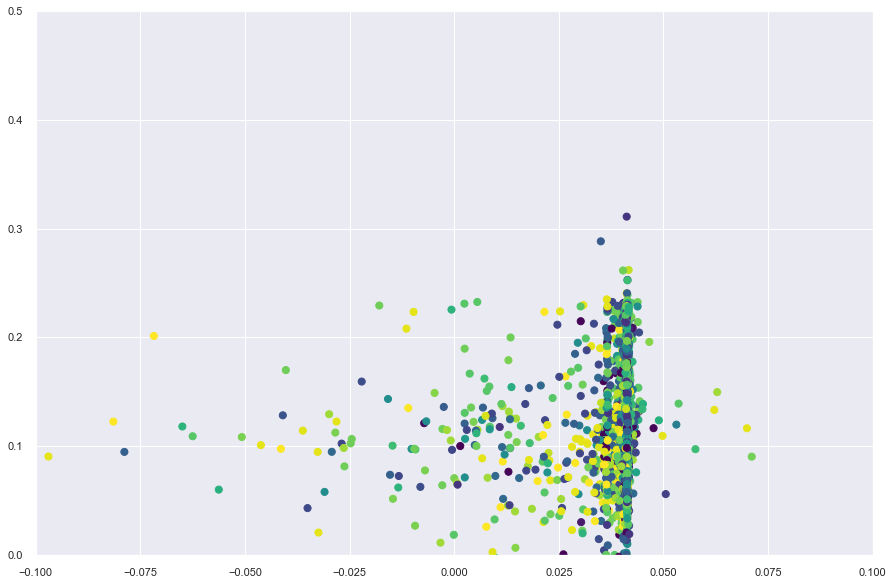

In [78]:
plt.figure(figsize = [15,10])
plt.axis([-0.1,0.1,0,0.5])
plt.scatter(complete1_scaled[:, 4], 
            complete1_scaled[:, 5], c=pred_alt, s=50, cmap='viridis');

Adding another dimension to our plots highlights a slightly more pronounced separation of the clusters

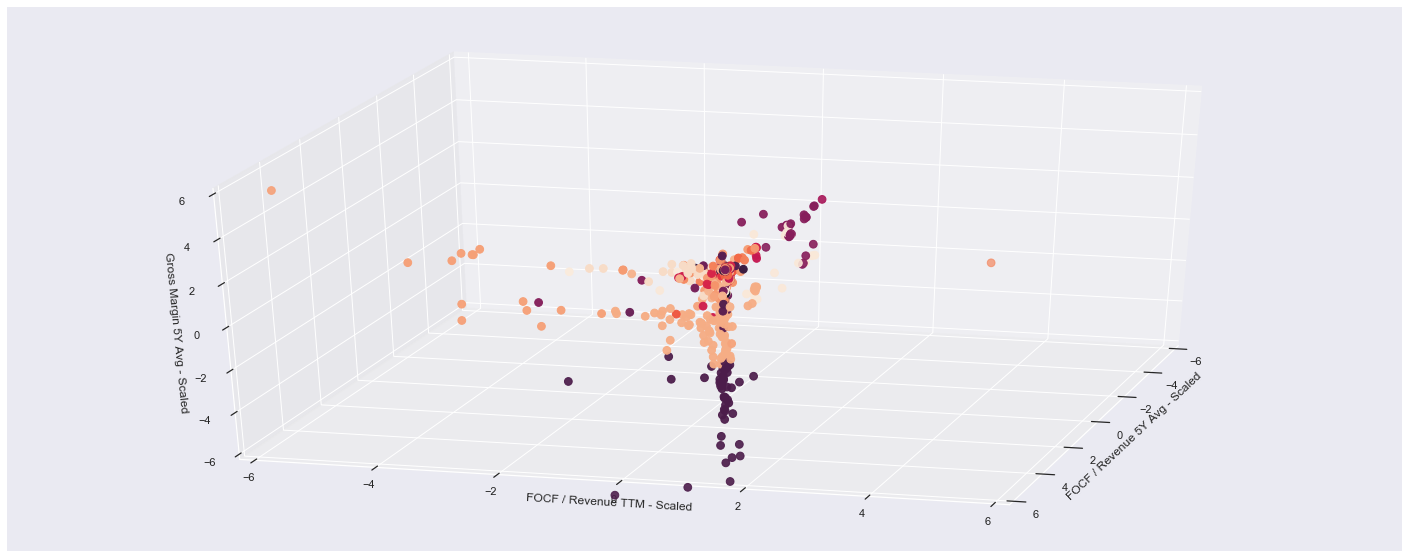

In [79]:
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('FOCF / Revenue 5Y Avg - Scaled')
ax.set_ylabel('FOCF / Revenue TTM - Scaled')
ax.set_zlabel('Gross Margin 5Y Avg - Scaled')
ax.scatter(complete1_scaled[:,3], complete1_scaled[:,4], complete1_scaled[:,5], c=pred_alt, s=60)
ax.set_xlim3d(-6, 6)
ax.set_ylim3d(-6,6)
ax.set_zlim3d(-6,6)
ax.view_init(30, 15)
plt.show()

## Inspecting cluster consituents

In [80]:
findata_w_clusters = pd.merge(df, alt_df_2, left_index = True, right_index = True)

In [81]:
findata_w_clusters.drop(columns = ['index', 'companies'], inplace = True)

We have tagged back each of the companies to its assigned cluster

In [84]:
findata_w_clusters.iloc[:,1:29]

,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,metric.netProfitMargin%Annual,metric.netProfitMargin5Y,metric.dividendGrowthRate5Y,...,metric.longTermDebt/equityAnnual,metric.netInterestCoverageAnnual,metric.payoutRatioAnnual,metric.quickRatioAnnual,metric.totalDebt/totalEquityAnnual,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual,company cluster
0,410825.3000,1934379.000,11.284440,19.40911,18.63398,38.718250,37.817770,21.23809,21.89832,11.229900,...,101.457600,23.609307,25.570070,1.501290,119.404800,1.486500,1.275840,1.352890,40.134460,59
1,133155.3000,442932.000,6.690699,29.93606,61.20183,52.764357,54.018287,30.06225,25.11008,38.208420,...,81.795250,22.797158,23.640280,0.788504,161.458000,1.589900,3.594610,12.762828,7.640894,65
2,16052.5800,388131.400,15.074940,6.57306,7.71885,38.289440,40.990010,4.13586,2.87305,19.595689,...,65.273930,18.933590,38.788651,0.863630,67.379950,2.882723,5.395433,28.074190,8.788510,59
3,58268.4800,705031.100,6.973920,5.05381,7.91697,53.188140,53.562780,8.26467,8.60255,2.041380,...,82.134500,3.773710,108.115100,0.753100,88.560480,5.342350,7.574650,-1.722560,29.863710,13
4,-155641.0000,3219231.000,170.816300,3.70202,6.06133,47.072970,50.629230,-4.83473,25.37806,12.018900,...,434.619100,23.397624,188.957059,0.309640,450.691100,4.390640,8.981560,8.579920,5.362020,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8642,-849453.9355,1670097.475,12.043480,4.81754,47.59596,84.209640,84.556760,39.95187,47.65050,-1.389070,...,0.595290,8.423310,106.726900,4.053382,17.737900,3.204510,3.577780,-47.469440,141.611651,21
8643,-810546.1370,7293925.835,202.307575,-3.03933,-0.16750,82.212780,65.077754,106.46740,106.24440,11.081378,...,1.946025,-754.042359,63.378094,2.305304,4.867440,7.627042,15.961122,-6.547941,32.584788,79
8644,71174.8035,561054.520,9.350430,-39.89987,-169.99190,24.898900,19.561240,-76.23400,-10.26382,0.707898,...,0.475960,-0.369370,42.401914,0.166510,30.890050,4.194674,14.894328,35.637490,0.169430,85
8645,29784.9700,428386.900,5.106880,0.05188,1.38347,62.201700,64.207170,6.95282,8.72242,-0.471700,...,90.966390,33.200000,130.026800,0.713080,98.704480,3.974600,4.820940,2.784790,15.404580,73


Let's compare now two clusters and see what differentiates them
   
   - We select smaller clusters to simplify our observation process.

In [128]:
cl51 = findata_w_clusters.loc[findata_w_clusters['company cluster'] == 51].describe()
cl52 = findata_w_clusters.loc[findata_w_clusters['company cluster'] == 52].describe()
cl51

,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,metric.netProfitMargin%Annual,metric.netProfitMargin5Y,metric.dividendGrowthRate5Y,...,metric.longTermDebt/equityAnnual,metric.netInterestCoverageAnnual,metric.payoutRatioAnnual,metric.quickRatioAnnual,metric.totalDebt/totalEquityAnnual,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual,company cluster
count,3.300000e+01,3.300000e+01,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,...,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.0
mean,-5.302821e+05,1.914792e+06,8.474326,-21499.063617,-9779.243192,-55.323360,-493.251152,-1583.440912,-17613.279771,2.836253,...,7.608829,-369.973775,61.667637,29.810565,8.266651,4.097309,10.350640,-2.249667,34.693418,51.0
std,2.152768e+06,6.885623e+06,9.148985,47039.609835,27239.989865,274.087658,2622.672681,6348.761416,43772.497198,6.122705,...,23.479760,1027.464679,50.909683,12.836356,23.467177,2.483167,6.371833,26.482742,61.558952,0.0
min,-1.054478e+07,1.021814e+05,0.033760,-146882.078879,-106323.835838,-1187.922249,-15004.790000,-36136.040000,-186102.909860,-7.303742,...,0.000000,-5604.891000,0.000000,18.769520,0.000000,0.000000,2.307690,-60.717480,0.176470,51.0
25%,-8.329097e+05,2.538571e+05,2.591360,-15206.711234,-826.426250,8.684900,2.471610,-649.099519,-14534.555627,-1.319086,...,0.000000,-196.237400,31.686349,22.527226,0.000000,2.268492,5.709156,-14.753627,2.493520,51.0
50%,-2.727166e+05,5.189356e+05,6.832550,-229.828100,-111.930200,32.865080,32.443616,-69.871470,-81.480740,2.256413,...,0.000000,-37.165511,45.593387,23.860460,0.000000,3.684483,6.819687,-3.544462,8.475484,51.0
75%,2.888385e+04,9.280846e+05,10.978789,-12.755680,-19.837750,46.123575,62.412080,1.173464,4.885410,5.715392,...,1.012970,0.613710,91.436598,33.597510,2.141340,4.474978,13.870685,13.461884,32.752814,51.0
max,5.448502e+06,4.009467e+07,48.323170,45.621750,77.506330,95.037220,90.566340,523.188800,1597.257815,22.247617,...,94.048950,240.750000,192.246437,71.400520,94.159450,10.777522,24.924710,61.680690,280.376600,51.0


In [111]:
cl51_mean = cl51[1:2].T.round(1).reset_index()
cl52_mean = cl52[1:2].T.round(1).reset_index()

In [126]:
cl5152 = pd.merge(cl51_mean, cl52_mean, on = 'index').rename(columns = {'index': 'metric', 'mean_x':'cl51_average', 'mean_y':'cl52_average'})

Some Observations at the cluster level: 

   - Outliers in the data are skewing some of the metrics (e.g. Average Net Profit Margin over 5 year-period)
   - Overall cl52 seems to contain more high gross margin businesses with high amounts of debt (some of the metrics in CL51 indicates some potentially distressed companies)
   - Both clusters seem to suffer from high depreciation & amortization + interest / tax expenses which suggest a high amount of asset and asset servicing costs




In [117]:
cl5152

,metric,cl51,cl52
0,metric.netIncomeEmployeeAnnual,-530282.1,-185388.1
1,metric.revenueEmployeeAnnual,1914791.5,1231905.6
2,metric.receivablesTurnoverAnnual,8.5,12.7
3,metric.freeOperatingCashFlow/revenue5Y,-21499.1,-1092.3
4,metric.freeOperatingCashFlow/revenueTTM,-9779.2,-46.6
5,metric.grossMargin5Y,-55.3,34.3
6,metric.grossMarginAnnual,-493.3,50.8
7,metric.netProfitMargin%Annual,-1583.4,-2.1
8,metric.netProfitMargin5Y,-17613.3,-1403.2
9,metric.dividendGrowthRate5Y,2.8,0.0


In [123]:
cl52_comp = findata_w_clusters.loc[findata_w_clusters['company cluster'] == 52]

Peek into Cluster 52: 

 - Main metric contributing to cl52 seems to be Gross Margin
 - Sectors include: Industrials, Financial Servicem Real Estate and Entertainment
 - cl52 could serve as a basic screen if you're scouting for high gross margin businesses

In [127]:
cl52_comp.merge(tickers, left_on = 'symbol', right_on = 'Ticker')

,symbol,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,metric.netProfitMargin%Annual,metric.netProfitMargin5Y,...,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual,company cluster,Unnamed: 0,Ticker,Name,Exchange,Category Name,Country
0,PCG,-3.251915e+05,7.288936e+05,14.068990,-9.838400,-8.739560,50.649986,51.153900,-44.61440,-12.148920,...,5.857643,5.488180,20.905910,52,4048,PCG,PG&E Corporation,NYQ,Electric Utilities,USA
1,CSBR,1.236715e+03,2.615169e+05,6.526890,-26.045140,-0.713990,38.572330,47.297450,0.47290,-38.444250,...,8.854091,28.940700,70.691124,52,4913,CSBR,iShares MSCI Brazil ETF USD Acc,NCM,Biotechnology,USA
2,CTO,-8.116153e+04,1.570093e+06,19.543290,-163.223800,-303.712300,75.341960,84.191210,36.94888,33.130420,...,2.320190,27.845690,30.632314,52,5291,CTO,Consolidated-Tomoka Land Co.,ASE,Real Estate Development,USA
3,LYV,1.182120e+04,1.154797e+06,12.324620,3.599470,0.900210,29.978930,30.598340,1.02366,0.346820,...,16.576292,20.677480,558.870500,52,7106,LYV,"Live Nation Entertainment, Inc.",NYQ,Entertainment - Diversified,USA
4,LTS,2.337323e+04,9.623909e+05,38.317500,-1.066010,-0.795420,24.417820,27.066010,2.42866,0.854650,...,1.428570,16.156640,26.955133,52,8363,LTS,Ladenburg Thalmann Financial Services Inc.,ASE,Investment Brokerage - National,USA
5,GSIT,1.009288e+03,3.187988e+05,8.160720,0.980510,1.225420,53.242300,61.430290,0.31659,-4.565410,...,7.295813,22.391800,3.535970,52,9587,GSIT,"GSI Technology, Inc.",NMS,Semiconductor - Broad Line,USA
6,HR,1.365331e+05,1.638669e+06,41.435950,-59.128550,-82.323300,62.975650,61.725330,8.33195,12.883240,...,4.748710,25.561370,28.740327,52,10462,HR,Healthcare Realty Trust Incorporated,NYQ,REIT - Healthcare Facilities,USA
7,HLIT,-5.076264e+03,3.452219e+05,4.283660,-0.246560,5.204360,51.988840,55.700540,-1.47043,-9.414690,...,7.890897,0.517220,6.527830,52,10538,HLIT,Harmonic Inc.,NMS,Communication Equipment,USA
8,PTC,-4.514591e+03,2.064334e+05,5.002120,13.959280,18.218290,72.912200,74.086500,-2.18695,0.189160,...,8.871148,20.574030,20.893569,52,11869,PTC,PTC Inc.,NMS,Technical & System Software,USA
9,LIQT,-1.061043e+06,1.369629e+06,5.945860,-14.759235,-603.160600,15.223780,21.945050,0.12139,-31.236550,...,8.701411,41.291660,5.290080,52,15634,LIQT,"LiqTech International, Inc.",ASE,Pollution & Treatment Controls,USA
